In [1]:
#Imports
import xarray as xr
import numpy as np
import pandas as pd
from collections import OrderedDict
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from cartopy import config
import cartopy.crs as ccrs

In [2]:
# Returns equvalent to cdo fldmean
def fldmean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    return ds.mean(("lon", "lat"))

In [110]:
#Define paths
obs_path='obs/'
model_path='input/'
out_path='output/'
eval_path='eval/'
time = '198912-201411'

'''
Define model(s) and the respective variable dicts. (some models dont have the full set of variables available). 
I'd like to write this in a less verbose way, but it seems to involve conversion of string into variable 
via exec() locals() or globals(). I want that even less than long dict def.
'''

obs = { 'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'}



models = {
    'AWICM3':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
}
#Define evaluation models
eval_models = {
    'AWICM3':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'}}
    
'''
#Define evaluation models
eval_models = {
    'ACCESS-ESM1-5':{
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'AWI-CM1-MR':{
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'AWI-ESM1-LR':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'BCC':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'CAMS':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'CAS-ESM2-0':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'CAN5':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'CESM2':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':'ERA5',
        'zg':'ERA5'},
    'CIESM':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':'ERA5',
        'zg':'ERA5'},
    'CMCC-CM2-SR5':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'CNRM6':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'E3SM-1-1':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':'ERA5',
        'zg':'ERA5'},
    'EC-Earth3':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'FGOALS-f3-L':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'FGOALS-g3':{
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':'ERA5',
        'zg':'ERA5'},
    'FIO2':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP'},
    'GISS-E2-1-G':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'HadGEM3MM':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'HAMMOZ':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'INM5':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'IITM':{
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',},
    'IPSL-CM6A-LR':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'KACE-1-0-G':{
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'KIOST-ESM':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'MCMUA1':{
        'tas':'ERA5',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'MIROC6':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'MPI-ESM1-2-LR':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'MRI':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'NESM3':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'NORESM2':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':'ERA5',
        'zg':'ERA5'},
    'NOAA-GFDL':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'},
    'SNU': {   
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':'ERA5',
        'zg':'ERA5'},
    'TAIESM':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':'ERA5',
        'zg':'ERA5'},
    'UKESM1-0-LL':{
        'siconc':'OSISAF',
        'tas':'ERA5',
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':'ERA5',
        'vas':'ERA5',
        'ua':'ERA5',
        'zg':'ERA5'}
}


#Define regions
regions={'glob' : {
    'lat_min':-90,
    'lat_max':90,},
         
    'arctic' : {
    'lat_min':60,
    'lat_max':90,},
         
    'northmid' : {
    'lat_min':30,
    'lat_max':60,},
         
    'tropics' : {
    'lat_min':-30,
    'lat_max':30,},
         
    'innertropics' : {
    'lat_min':-15,
    'lat_max':15,},
         
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,},
         
    'antarctic' : {
    'lat_min':-90,
    'lat_max':-60,}
          
}
'''

#Define seasons
seasons = ['MAM', 'JJA', 'SON', 'DJF']



In [111]:
#Loading obs data
ds_obs = OrderedDict()
for var in obs:
    for seas in seasons:
        print('loading '+obs_path+var+'_'+obs[var]+'_'+seas+'.nc')

        intermediate = xr.open_dataset(obs_path+var+'_'+obs[var]+'_'+seas+'.nc')
        ds_obs[var,seas] = intermediate.compute()

loading obs/siconc_OSISAF_MAM.nc
loading obs/siconc_OSISAF_JJA.nc
loading obs/siconc_OSISAF_SON.nc
loading obs/siconc_OSISAF_DJF.nc
loading obs/tas_ERA5_MAM.nc
loading obs/tas_ERA5_JJA.nc
loading obs/tas_ERA5_SON.nc
loading obs/tas_ERA5_DJF.nc
loading obs/clt_MODIS_MAM.nc
loading obs/clt_MODIS_JJA.nc
loading obs/clt_MODIS_SON.nc
loading obs/clt_MODIS_DJF.nc
loading obs/pr_GPCP_MAM.nc
loading obs/pr_GPCP_JJA.nc
loading obs/pr_GPCP_SON.nc
loading obs/pr_GPCP_DJF.nc
loading obs/rlut_CERES_MAM.nc
loading obs/rlut_CERES_JJA.nc
loading obs/rlut_CERES_SON.nc
loading obs/rlut_CERES_DJF.nc
loading obs/uas_ERA5_MAM.nc
loading obs/uas_ERA5_JJA.nc
loading obs/uas_ERA5_SON.nc
loading obs/uas_ERA5_DJF.nc
loading obs/vas_ERA5_MAM.nc
loading obs/vas_ERA5_JJA.nc
loading obs/vas_ERA5_SON.nc
loading obs/vas_ERA5_DJF.nc
loading obs/ua_ERA5_MAM.nc
loading obs/ua_ERA5_JJA.nc
loading obs/ua_ERA5_SON.nc
loading obs/ua_ERA5_DJF.nc
loading obs/zg_ERA5_MAM.nc
loading obs/zg_ERA5_JJA.nc
loading obs/zg_ERA5_SON.nc

In [112]:
#Loading model data
ds_model = OrderedDict()
for model in models:
    for var in models[model]:
        for seas in seasons:
            print('loading '+model_path+var+'_'+model+'_'+time+'_'+seas+'.nc')
            intermediate = xr.open_dataset(model_path+var+'_'+model+'_'+time+'_'+seas+'.nc')
            ds_model[var,seas,model] = intermediate.compute()

loading input/siconc_AWICM3_198912-201411_MAM.nc
loading input/siconc_AWICM3_198912-201411_JJA.nc
loading input/siconc_AWICM3_198912-201411_SON.nc
loading input/siconc_AWICM3_198912-201411_DJF.nc
loading input/tas_AWICM3_198912-201411_MAM.nc
loading input/tas_AWICM3_198912-201411_JJA.nc
loading input/tas_AWICM3_198912-201411_SON.nc
loading input/tas_AWICM3_198912-201411_DJF.nc
loading input/clt_AWICM3_198912-201411_MAM.nc
loading input/clt_AWICM3_198912-201411_JJA.nc
loading input/clt_AWICM3_198912-201411_SON.nc
loading input/clt_AWICM3_198912-201411_DJF.nc
loading input/pr_AWICM3_198912-201411_MAM.nc
loading input/pr_AWICM3_198912-201411_JJA.nc
loading input/pr_AWICM3_198912-201411_SON.nc
loading input/pr_AWICM3_198912-201411_DJF.nc
loading input/rlut_AWICM3_198912-201411_MAM.nc
loading input/rlut_AWICM3_198912-201411_JJA.nc
loading input/rlut_AWICM3_198912-201411_SON.nc
loading input/rlut_AWICM3_198912-201411_DJF.nc
loading input/uas_AWICM3_198912-201411_MAM.nc
loading input/uas_AWIC

In [113]:
#Calculate absolute error and build field mean of abs error
abs_error = OrderedDict()
mean_error = OrderedDict()
for model in models:
    for var in models[model]:
        for region in regions:
            if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
                continue
            filter1 = ds_model[var,seas,model].drop('time').lat>regions[region]['lat_min']
            filter2 = ds_model[var,seas,model].drop('time').lat<regions[region]['lat_max']
            for seas in seasons:
                abs_error[var,seas,model,region]=np.sqrt((ds_model[var,seas,model].drop('time').where(filter1 & filter2)-
                                                   ds_obs[var,seas].drop('time')).where(filter1 & filter2)*
                                                  (ds_model[var,seas,model].drop('time').where(filter1 & filter2)-
                                                   ds_obs[var,seas].drop('time').where(filter1 & filter2)))
                mean_error[var,seas,model,region] = fldmean(abs_error[var,seas,model,region])

In [114]:
#Write field mean of errors into csv files
for model in models:
    with open(out_path+'abs/'+model+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Season','AbsMeanError'])
        for var in models[model]:
            for region in regions:
                if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
                    continue
                for seas in seasons:
                    if (var == 'tas'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].tas.values[0]])
                    if (var == 'uas'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].uas.values[0]])
                    if (var == 'vas'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].vas.values[0]])
                    if (var == 'ua'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].ua.values[0][0]])
                    if (var == 'zg'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].zg.values[0][0]])
                    if (var == 'pr'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].pr.values[0]])
                    if (var == 'rlut'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].rlut.values[0]])
                    if (var == 'clt'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].clt.values[0]])
                    if (var == 'siconc'):
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].siconc.values[0]])

In [115]:
#Read precalculated cmip6 field mean of errors from csv files
collect = np.empty([len(eval_models),len(obs),len(regions),len(seasons)])*np.nan
i=0
for eval_model in eval_models:
    df = pd.read_csv(eval_path+eval_model+'.csv', delimiter=' ')
    values = df['AbsMeanError'] #you can also use df['column_name']
    j=0
    r=0
    for var in obs:
        k=0
        a=(df['Variable']==var).to_list()
        if any(a): # Check if variable appears in list. If not, skip it.
            print('reading',eval_model,var)
            pass
        else:
            j+=1
            print('skipping',eval_model,var)
            continue
        for region in regions:
            l=0
            if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
                continue
            for seas in seasons:
                collect[i,j,k,l]=values[r]
                l+=1
                r+=1
            k+=1
        j+=1
    i+=1
ensmean=np.nanmean(collect,axis=0)

reading AWICM3 siconc
reading AWICM3 tas
reading AWICM3 clt
reading AWICM3 pr
reading AWICM3 rlut
reading AWICM3 uas
reading AWICM3 vas
reading AWICM3 ua
reading AWICM3 zg


/tmp/ipykernel_15316/2810231248.py:30: RuntimeWarning: Mean of empty slice
  ensmean=np.nanmean(collect,axis=0)


In [116]:
#Place sums of error into easier to inspect dictionary
eval_error_mean = OrderedDict()
j=0
for var in obs:
    k=0
    for region in regions:
        l=0
        if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
            continue
        for seas in seasons:
            eval_error_mean[var,region,seas]=ensmean[j,k,l]
            l+=1
        k+=1
    j+=1

In [117]:
#calculate ratio of current model error to evaluation model error
error_fraction = OrderedDict()
sum=0
for model in models:
    for var in models[model]:
        for region in regions:
            if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
                continue
            for seas in seasons:
                error_fraction[var,seas,model,region] = mean_error[var,seas,model,region] / eval_error_mean[var,region,seas]


In [118]:
#Write ratio of field mean of errors into csv files and sum up error fractions for cmpi score
#TODO beautification: find way to access error_fraction[var,seas,model,region].var.values[0] to make
#one call out of nine
cmpi = OrderedDict()
for model in models:
    sum=0
    iter=0
    with open(out_path+'frac/'+model+'_fraction.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Season','FracMeanError'])
        for var in models[model]:
            for region in regions:
                if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
                    continue
                for seas in seasons:
                    if (var == 'tas'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].tas.values[0]])
                        sum+=error_fraction[var,seas,model,region].tas.values[0]
                    if (var == 'uas'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].uas.values[0]])
                        sum+=error_fraction[var,seas,model,region].uas.values[0]
                    if (var == 'vas'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].vas.values[0]])
                        sum+=error_fraction[var,seas,model,region].vas.values[0]
                    if (var == 'ua'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].ua.values[0][0]])
                        sum+=error_fraction[var,seas,model,region].ua.values[0][0]
                    if (var == 'zg'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].zg.values[0][0]])
                        sum+=error_fraction[var,seas,model,region].zg.values[0][0]
                    if (var == 'pr'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].pr.values[0]])
                        sum+=error_fraction[var,seas,model,region].pr.values[0]
                    if (var == 'rlut'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].rlut.values[0]])
                        sum+=error_fraction[var,seas,model,region].rlut.values[0]
                    if (var == 'clt'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].clt.values[0]])
                        sum+=error_fraction[var,seas,model,region].clt.values[0]
                    if (var == 'siconc'):
                        writer.writerow([var,region,seas,error_fraction[var,seas,model,region].siconc.values[0]])
                        sum+=error_fraction[var,seas,model,region].siconc.values[0]
                    iter+=1
        cmpi[model]=sum/iter
        writer.writerow(['CMPI','global','yearly',cmpi[model]])

reading AWICM3 siconc
reading AWICM3 tas
reading AWICM3 clt
reading AWICM3 pr
reading AWICM3 rlut
reading AWICM3 uas
reading AWICM3 vas
reading AWICM3 ua
reading AWICM3 zg


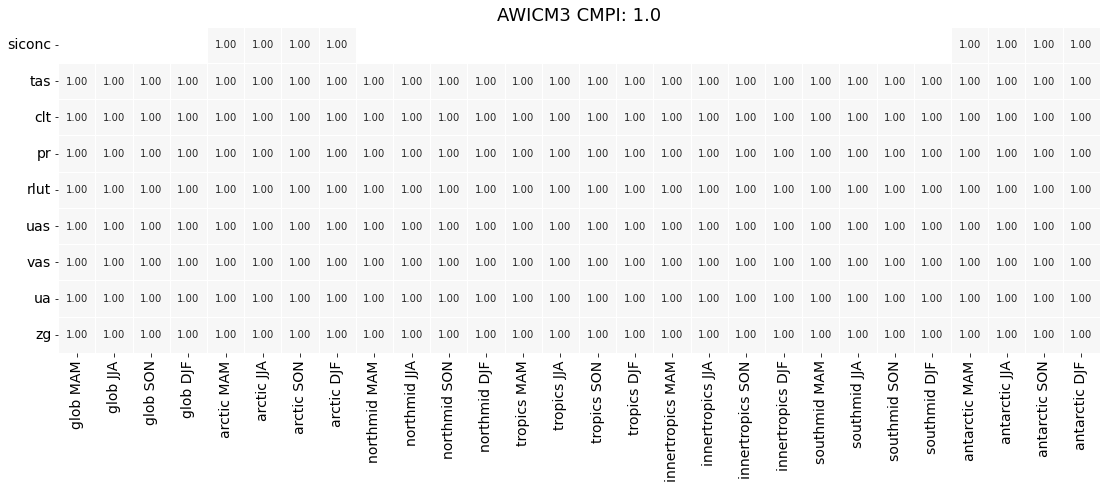

In [119]:
#Read precalculated evaluation field means of errors from csv files and plot heatmap
collect_frac = np.empty([len(models),len(obs),len(regions),len(seasons)])*np.nan
i=0
for model in models:
    df = pd.read_csv(out_path+'frac/'+model+'_fraction.csv', delimiter=' ')
    values = df['FracMeanError'] #you can also use df['column_name']
    j=0
    r=0
    for var in obs:
        k=0
        a=(df['Variable']==var).to_list()
        if any(a): # Check if variable appears in list. If not, skip it.
            print('reading',model,var)
            pass
        else:
            j+=1
            print('skipping',model,var)
            continue
        for region in regions:
            l=0 # Check if combination of variable and region appears in list. If not, skip it.
            if np.max(np.add(list(map(int, (df['Variable']==var).to_list())),list(map(int, (df['Region']==region).to_list())))) ==2:
                pass
            else:
                k+=1
                continue
            for seas in seasons:
                collect_frac[i,j,k,l]=values[r]
                l+=1
                r+=1
            k+=1
        j+=1
    collect_frac_reshaped = collect_frac[i,:,:,:].reshape(len(obs),len(regions)*len(seasons))
    #collect_frac_reshaped = collect_frac[i,:,:,:].reshape(j,k*l)

    seasons_plot = [' MAM', ' JJA', ' SON', ' DJF'] #adding spaces in front
    a=seasons_plot*len(regions)
    b=np.repeat(list(regions.keys()),len(seasons_plot))
    coord=[n+str(m) for m,n in zip(a,b)]
    collect_frac_dataframe = pd.DataFrame(data=collect_frac_reshaped, index=obs, columns=coord)
    
    fig, ax = plt.subplots(figsize=(len(coord)/1.5,len(obs)/1.5))
    fig.patch.set_facecolor('white')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = sns.heatmap(collect_frac_dataframe, vmin=0.5, vmax=1.5,center=1,annot=True,fmt='.2f',cmap="PiYG_r",cbar=False,linewidths=1)
    plt.xticks(rotation=90,fontsize=14)
    plt.yticks(rotation=0, ha='right',fontsize=14)
    plt.title(model+' CMPI: '+str(round(cmpi[model],3)), fontsize=18)
    
    plt.savefig(out_path+'plot/'+model+'.png',dpi=150,bbox_inches='tight')
    i+=1
